# Variationa Monte Carlo for 1D quantum mechanics

In this notebook we will see how to use Monte Carlo methods in quantum mechanics.
We will implement a Variational Monte Carlo algorithm (VMC) for a particle in one dimension under the action of a potential $$V(x)=x^4 +\frac{5}{2}x^{2} $$ not analytically soluble.

The code in this directory is divided as follows:

- <code> vmc.h </code> and <code> vmc.cpp </code> cointain all the functions used for the sampling, the integral calculation and the optimizers
- <code> random.h </code> and <code> random.cpp </code> contain the parallel random number genetaor (from prof. Davide Galli)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
import math

### Metropolis sampling for integrals calculation

In this part of the notebook we will show how our code is able to calculate the expectation value of the Hamiltonian over a trial wave function $$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$
with $\mu=1$ and $\sigma=0.5$ using the blocking technique.

Conventions:

$\hbar=1$, $m=1$

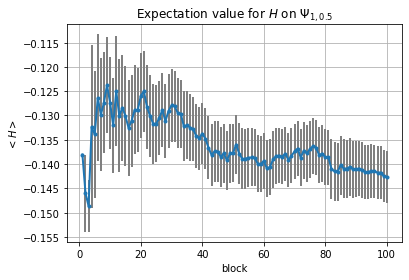

In [12]:
#Here we plot the example data

ex=open("VMC/example.dat","r").read().split("\n")
ex=[x.split(" ") for x in ex]

x=[]
y=[]
y_err=[]

for i in range(len(ex)):
    x.append(float(ex[i][0]))
    y.append(float(ex[i][1]))
    y_err.append(float(ex[i][2]))
    
plt.errorbar(x,y,yerr=y_err,marker=".",lw=2,ecolor='gray')
plt.title('Expectation value for $H$ on $\Psi_{1,0.5}$')
plt.xlabel('block') 
plt.ylabel('$<H>$')
plt.grid(True)

plt.show()
plt.close()

### Variational Monte Carlo

Then comes the "variational" part of the VMC.

- Our first idea was to design a "Gradient Descent" algorithm. This means that if we want to minimize a function $f(x)$ over the parameters $x_{i}$, at each step $t$ we have:

$$
x_{i}(t+1)=x_{i}(t)-\eta*\frac{\partial f}{\partial x_{i}}
$$

where $\eta$ is the learning rate.
The problem is how to calculate the derivative. Then hint comes from quantum computing, where you don't have access to analytical form of the function, but only its numerical values from measurement. Therefore a "derivative" that is an incremental ratio is calculated
$$
\frac{\partial f}{\partial x_{i}} \sim \frac{f(x_{i}+h,x_{k})-f(x_{i},x_{k})}{h}
$$

when h is sufficiently small.

This "sufficiently small" has a lower bound; the statistical uncertainty we have in calculating f as a Monte Marlo integral. This is not a problem since the error on the integral calulation is sufficiently small to let us choose $h=0.1$.

Unfortunately, due to the nature of the function to minimize, namely $E_{loc}(\sigma,\mu)$, this algorithm is not guaranteed to converge. Moreover, it turn out to be very unstable, also when annealing factor are applied to the learning rate.


- The second idea is therefore to proceed with simulated annealing.

The algorithm works like this:

1) calculate $E_{loc}(\sigma,\mu)$

2) randomly generate two new parameters $\sigma_{new}$ and $\mu_{new}$

3) if $E_{loc}(\sigma_{new},\mu_{new}) < E_{loc}(\sigma,\mu)$, the new parameters are the best found until now, so accept the move, otherwise, if the new energy is greater than before,a ccept the move only with a probability $e^{-\frac{t}{\tau}}$, where $t$ is the number of steps and $\tau$ is a fine-tuned temperature for the system

4) repeat step 2 and 3 until the parameters do not change anymore

Also this method is not guaranteed to converge, but it proved to be very stable.

Results are:

$\mu = 0.774863$

$\sigma = 0.631326$

Those values gave an approximate ground state energy $E_{GS}=-0.459931$

Now we can use those new parameters to calculate the ground state energy with metropolis algorithm and the blocking technique.


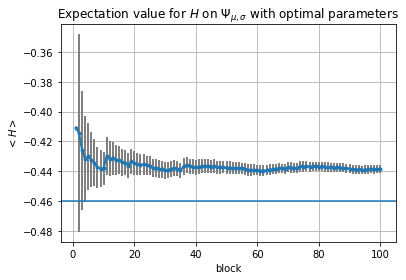

In [8]:
#Here we plot the example data

ex=open("VMC/variational_energy_results.dat","r").read().split("\n")
ex=[x.split(" ") for x in ex]

x=[]
y=[]
y_err=[]

for i in range(len(ex)):
    x.append(float(ex[i][0]))
    y.append(float(ex[i][1]))
    y_err.append(float(ex[i][2]))
    
plt.errorbar(x,y,yerr=y_err,marker=".",lw=2,ecolor='gray')
plt.axhline(-0.46)
plt.title('Expectation value for $H$ on $\Psi_{\mu,\sigma}$ with optimal parameters')
plt.xlabel('block') 
plt.ylabel('$<H>$')
plt.grid(True)

plt.show()
plt.close()

We can also plot the $|\Psi|^{2}$ sampled and compare it to its analytic function and to the result obtained by solving the Schroedinger equation as a matrix equation

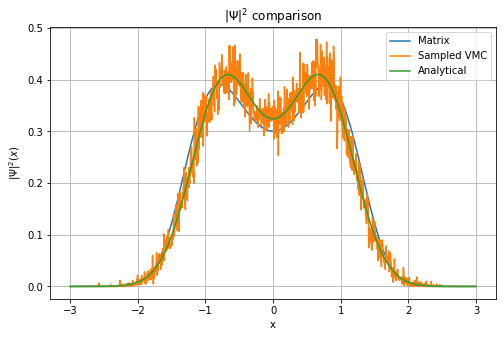

In [13]:
#=============================================
# Schroedinger equation as a matrix equation
#=============================================

def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 6
N = 1000 # number of iterations

# Step sizes
x1 = np.linspace(-a/2, a/2, N)
dx = x1[1] - x1[0] # the step size
V = Vpot(x1)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)



#================================================
# VMC sample
#================================================
wave=open("VMC/Wavefunction.dat","r").read().split("\n")
wave=[x.split(" ") for x in wave]

x2=[]
y2=[]

for i in range(len(wave)):
    x2.append(float(wave[i][0]))
    y2.append(float(wave[i][1]))
    
#Now normalize the histogram


N2=simps(y2,x2)

for j in range(len(y2)):
    y2[j]=y2[j]/N2

    
    
#================================================
# Analytical solution
#================================================

#Import optimal mu and sigma
mu = 0.774863
sigma = 0.631326

def Opt_Wave(x):
    return math.exp(-(x-mu)**2/(2*sigma**2))+math.exp(-(x+mu)**2/(2*sigma**2))

x3=x2
y3=[Opt_Wave(x)*Opt_Wave(x) for x in x3]

#Normalize again

N3=simps(y3,x3)

for j in range(len(y3)):
    y3[j]=y3[j]/N3
    
#=================================================
#And plot
plt.figure(figsize=(8,5))

plt.plot(x1,(psi[0])**2,label="Matrix")
plt.plot(x2,y2,label="Sampled VMC")
plt.plot(x3,y3,label="Analytical")
plt.title("$|\Psi|^{2}$ comparison")
plt.xlabel("x")
plt.ylabel("$|\Psi|^{2}(x)$")
plt.grid(True)
plt.legend()

plt.show()
plt.close()